# Import Library & Load data

In [1]:
# Import Library
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

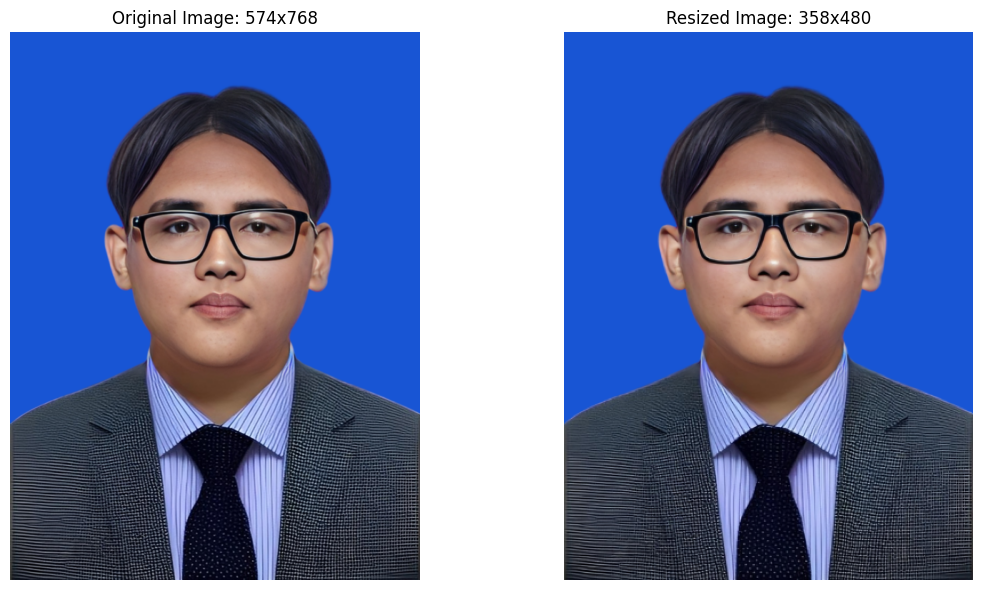

In [2]:
# Load image
img = cv.imread("data/18999687-c74f-419e-9377-8f4056b41612/abed_18.png")

# Convert to RGB
original_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Resize the image to the new size while maintaining aspect ratio
new_size = (480, 480)
height, width, _ = original_img.shape
scale = min(new_size[0] / width, new_size[1] / height)
new_width = int(width * scale)
new_height = int(height * scale)
resized_img = cv.resize(original_img, (new_width, new_height))

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image on the first subplot
ax1.imshow(original_img)
ax1.set_title(f'Original Image: {width}x{height}')
ax1.axis('off')

# Display the resized image on the second subplot
ax2.imshow(resized_img)
ax2.set_title(f'Resized Image: {new_width}x{new_height}')
ax2.axis('off')

plt.tight_layout()
plt.show()

In [3]:
# Import MTCNN for image detection
from mtcnn.mtcnn import MTCNN

# Initiate MTCNN Model
img_detector = MTCNN()
results = img_detector.detect_faces(resized_img)

1/1 [==============================] - 0s 126ms/step


In [4]:
# Show result
results

[{'box': [110, 103, 152, 186],
  'confidence': 0.9999997615814209,
  'keypoints': {'left_eye': (149, 169),
   'right_eye': (218, 170),
   'nose': (180, 203),
   'mouth_left': (155, 240),
   'mouth_right': (207, 240)}}]

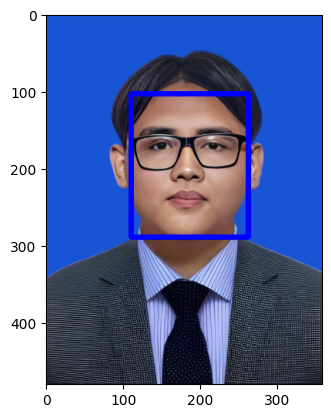

In [5]:
# Extract the coordinates and size of the bounding box from the first detection result
x,y,w,h = results[0]['box']

# Display the image with the drawn rectangle
img = cv.rectangle(resized_img, (x,y), (x+w, y+h), (0,0,255), 5)
plt.imshow(resized_img)

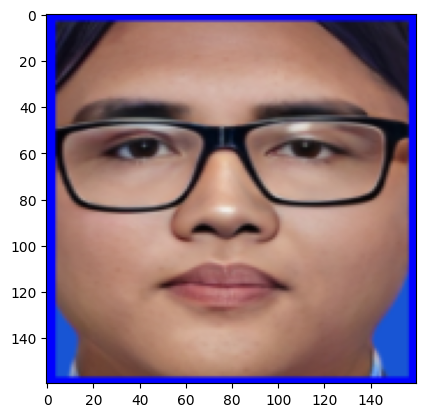

In [6]:
# resize image because Facenet takes as input 160x160
my_face = img[y:y+h, x:x+w]
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

# Automate the preprocessing 

In [7]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()
    
    def preprocess_image(self, filename, new_size=(480, 480)):
        # Load the image
        t_img = cv.imread(filename)

        # Convert the image to RGB
        t_img = cv.cvtColor(t_img, cv.COLOR_BGR2RGB)

        # Resize the image to the new size while maintaining aspect ratio
        height, width, _ = t_img.shape
        scale = min(new_size[0] / width, new_size[1] / height)
        new_width = int(width * scale)
        new_height = int(height * scale)
        resized_img = cv.resize(t_img, (new_width, new_height))

        # Detect faces in the resized image
        detections = self.detector.detect_faces(resized_img)
        if not detections:
            raise Exception("No faces detected in the image.")

        # Extract the coordinates and size of the bounding box from the first detection result
        x, y, w, h = detections[0]['box']

        # Scale the coordinates back to the original image size
        x = int(x / scale)
        y = int(y / scale)
        w = int(w / scale)
        h = int(h / scale)

        # Crop the detected face region from the original image using the bounding box coordinates
        face_img = t_img[y:y+h, x:x+w]

        # Resize the cropped face image to 160x160
        face_img = cv.resize(face_img, self.target_size)

        return face_img
    
    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = os.path.join(dir, im_name)
                single_face = self.preprocess_image(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = os.path.join(self.directory, sub_dir)
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)
        
        return np.asarray(self.X), np.asarray(self.Y)

In [8]:
# Initiate the FACELOADING class with the dataset directory path
faceloading = FACELOADING("data")

# Load the face images (X) and their corresponding labels (Y) from the dataset
X, Y = faceloading.load_classes()

1/1 [==============================] - 0s 29ms/step
Loaded successfully: 30
1/1 [==============================] - 0s 31ms/step
Loaded successfully: 30
1/1 [==============================] - 0s 21ms/step
Loaded successfully: 30
1/1 [==============================] - 0s 28ms/step
Loaded successfully: 30
1/1 [==============================] - 0s 34ms/step
Loaded successfully: 3


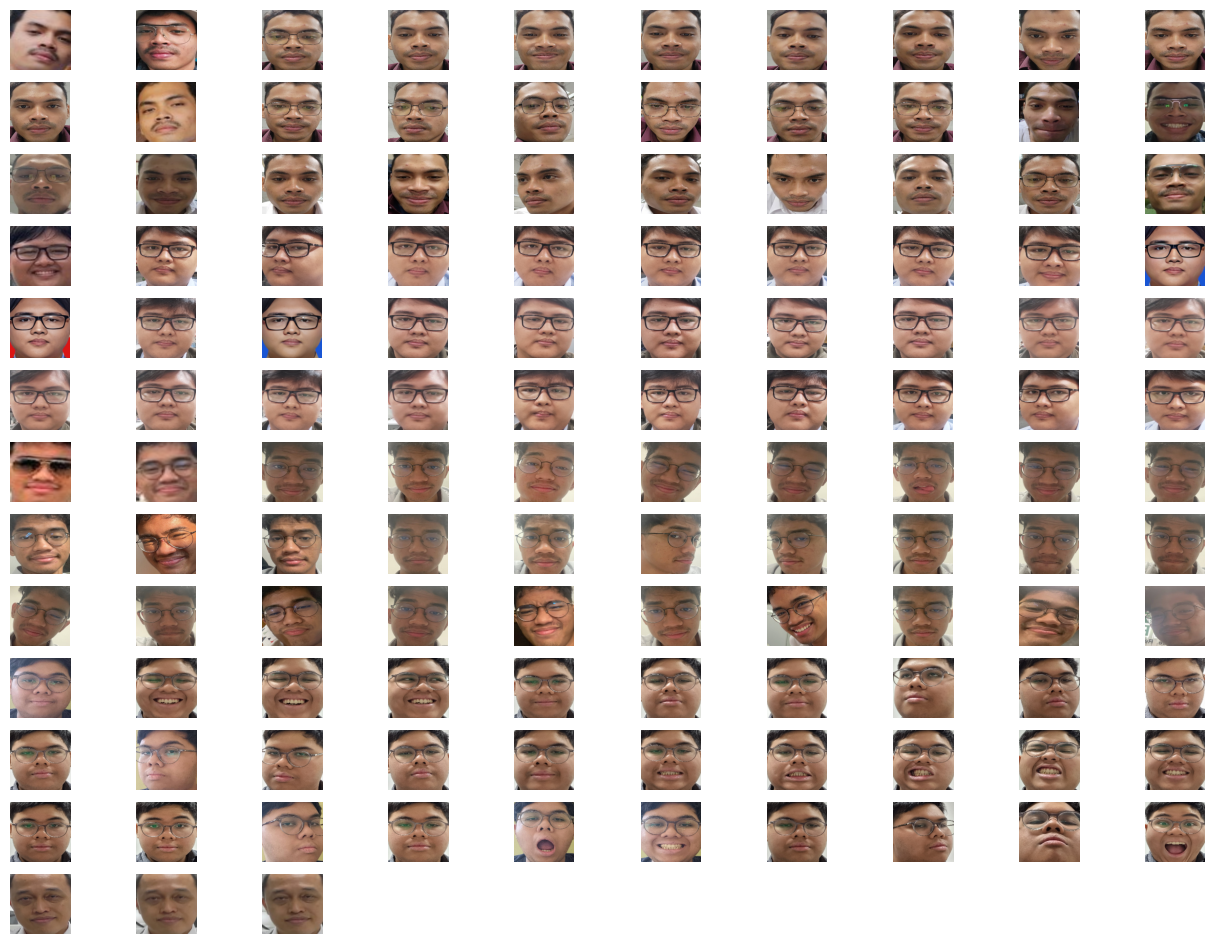

In [9]:
# display the loaded face images.
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 10
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

# FaceNet

In [10]:
# import library Facenet
from keras_facenet import FaceNet

# Instantiate the FaceNet model
embedder = FaceNet()

# Define a function to get the embedding of a face image
def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0) 
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [11]:
# Initialize an empty list to store embeddings
EMBEDDED_X = []

# Loop through each image in the dataset X to get the embedding for the current image and append it to the list
for img in X:
    EMBEDDED_X.append(get_embedding(img))

# Convert the list of embeddings to a NumPy array
EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 70ms/step


In [12]:
# Initialize an empty list to store unique labels in order
unique_labels = []

# Set to track seen labels
seen_labels = set()

# Iterate through each label in Y
for label in Y:
    # Check if the label has not been seen before
    if label not in seen_labels:
        # Add the label to the list of unique labels
        unique_labels.append(label)
        # Add the label to the set of seen labels
        seen_labels.add(label)

# Sort the unique labels
unique_labels.sort()

# Print unique labels in order
print("Labels:")
print(unique_labels)

# Write the unique labels to a text file
with open('labels.txt', 'w') as file:
    for label in unique_labels:
        file.write(f"{label}\n")

print("Labels have been saved to 'labels.txt' file.")

Labels:
['13b6aafe-ab44-4e90-a841-45b281462955', '18999687-c74f-419e-9377-8f4056b41612', '894f86f4-7309-4e4e-975c-90db5f586884', 'cabc5986-71cf-439d-bd8e-b285937f6fb5', 'e1b4262e-6346-4f82-8e7a-ff3a82888435']
Labels have been saved to 'labels.txt' file.


In [13]:
# Save the embeddings and labels into a compressed NumPy archive file (.npz)
np.savez_compressed('faces_embeddings_done.npz', EMBEDDED_X, Y)

# MLP Model

In [14]:
# import library label encoder
from sklearn.preprocessing import LabelEncoder

# Initiate a LabelEncoder object
encoder = LabelEncoder()

# Fit the LabelEncoder to the array Y to learn the classes
encoder.fit(Y)

# Transform the labels in Y to encoded labels
Y_encoded = encoder.transform(Y)

Text(0, 0.5, '13b6aafe-ab44-4e90-a841-45b281462955')

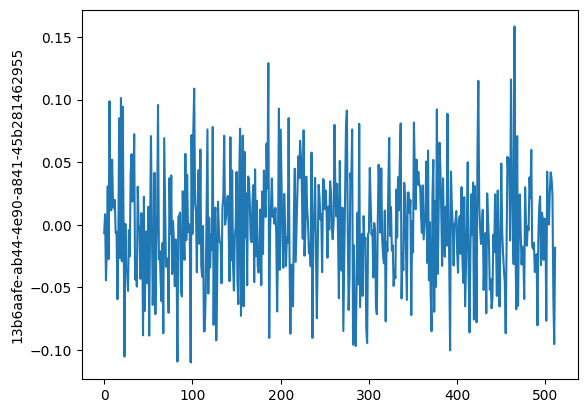

In [15]:
# Display plot values in EMBEDDED_X[0] and set the y-axis label to the value in Y[0]
plt.plot(EMBEDDED_X[0]) 
plt.ylabel(Y[0])

In [16]:
# Show labels
Y

array(['13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6aafe-ab44-4e90-a841-45b281462955',
       '13b6a

In [17]:
# Import train test split and Normalizer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and testing (20%)
X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y_encoded, test_size=0.2, shuffle=True, random_state=17)

# Membuat normalizer
Norm_encoder = Normalizer(norm='l2')

# Menerapkan normalisasi pada data pelatihan
X_train_norm = Norm_encoder.transform(X_train)

# Menerapkan normalisasi pada data pengujian
X_test_norm = Norm_encoder.transform(X_test)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
num_classes = len(np.unique(Y))
Y_train_categorical = to_categorical(Y_train, num_classes)
Y_test_categorical = to_categorical(Y_test, num_classes)

# Define the MLP model (128)
model_128 = Sequential()
model_128.add(Dense(128, input_shape=(X_train_norm.shape[1],), activation='relu'))
model_128.add(Dropout(0.5))
model_128.add(Dense(num_classes, activation='softmax'))

# Compile the model
model_128.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_128 = model_128.fit(X_train_norm, Y_train_categorical, epochs=100, batch_size=32, validation_data=(X_test_norm, Y_test_categorical))

# Evaluate the model
score_128 = model_128.evaluate(X_test_norm, Y_test_categorical, verbose=0)
print(f'Test loss: {score_128[0]} / Test accuracy: {score_128[1]}')

Epoch 1/100
4/4 [==============================] - 1s 118ms/step - loss: 1.5665 - accuracy: 0.4796 - val_loss: 1.4620 - val_accuracy: 0.9200
Epoch 2/100
4/4 [==============================] - 0s 14ms/step - loss: 1.4116 - accuracy: 0.9082 - val_loss: 1.3471 - val_accuracy: 0.9200
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 1.2918 - accuracy: 0.9694 - val_loss: 1.2399 - val_accuracy: 0.9200
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 1.1547 - accuracy: 0.9796 - val_loss: 1.1311 - val_accuracy: 0.9200
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 1.0403 - accuracy: 0.9796 - val_loss: 1.0166 - val_accuracy: 0.9200
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.9294 - accuracy: 0.9898 - val_loss: 0.9042 - val_accuracy: 0.9200
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.8060 - accuracy: 0.9796 - val_loss: 0.8046 - val_accuracy: 0.9200
Epoch 8/100
4/4 [==

In [19]:
# Define the MLP model (256)
model_256 = Sequential()
model_256.add(Dense(256, input_shape=(X_train_norm.shape[1],), activation='relu'))
model_256.add(Dropout(0.5))
model_256.add(Dense(num_classes, activation='softmax'))

# Compile the model
model_256.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_256 = model_256.fit(X_train_norm, Y_train_categorical, epochs=100, batch_size=32, validation_data=(X_test_norm, Y_test_categorical))

# Evaluate the model
score_256 = model_256.evaluate(X_test_norm, Y_test_categorical, verbose=0)
print(f'Test loss: {score_256[0]} / Test accuracy: {score_256[1]}')

Epoch 1/100
4/4 [==============================] - 1s 57ms/step - loss: 1.5177 - accuracy: 0.5816 - val_loss: 1.3833 - val_accuracy: 0.9200
Epoch 2/100
4/4 [==============================] - 0s 14ms/step - loss: 1.2889 - accuracy: 0.9592 - val_loss: 1.2253 - val_accuracy: 0.9200
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 1.1130 - accuracy: 0.9898 - val_loss: 1.0699 - val_accuracy: 0.9200
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9666 - accuracy: 0.9898 - val_loss: 0.9287 - val_accuracy: 0.9200
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.8070 - accuracy: 0.9898 - val_loss: 0.8050 - val_accuracy: 0.9200
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6717 - accuracy: 0.9898 - val_loss: 0.6970 - val_accuracy: 0.9200
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.5726 - accuracy: 0.9898 - val_loss: 0.6053 - val_accuracy: 0.9200
Epoch 8/100
4/4 [===

In [20]:
# Define the MLP model (512)
model_512 = Sequential()
model_512.add(Dense(512, input_shape=(X_train_norm.shape[1],), activation='relu'))
model_512.add(Dropout(0.5))
model_512.add(Dense(num_classes, activation='softmax'))

# Compile the model
model_512.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_512 = model_512.fit(X_train_norm, Y_train_categorical, epochs=100, batch_size=32, validation_data=(X_test_norm, Y_test_categorical))

# Evaluate the model
score_512 = model_512.evaluate(X_test_norm, Y_test_categorical, verbose=0)
print(f'Test loss: {score_512[0]} / Test accuracy: {score_512[1]}')

Epoch 1/100
4/4 [==============================] - 1s 62ms/step - loss: 1.5220 - accuracy: 0.6224 - val_loss: 1.3324 - val_accuracy: 0.9200
Epoch 2/100
4/4 [==============================] - 0s 18ms/step - loss: 1.2129 - accuracy: 0.9898 - val_loss: 1.1287 - val_accuracy: 0.9200
Epoch 3/100
4/4 [==============================] - 0s 16ms/step - loss: 0.9706 - accuracy: 0.9898 - val_loss: 0.9289 - val_accuracy: 0.9200
Epoch 4/100
4/4 [==============================] - 0s 16ms/step - loss: 0.7646 - accuracy: 0.9898 - val_loss: 0.7541 - val_accuracy: 0.9200
Epoch 5/100
4/4 [==============================] - 0s 16ms/step - loss: 0.5789 - accuracy: 0.9898 - val_loss: 0.6118 - val_accuracy: 0.9200
Epoch 6/100
4/4 [==============================] - 0s 16ms/step - loss: 0.4491 - accuracy: 0.9898 - val_loss: 0.5037 - val_accuracy: 0.9200
Epoch 7/100
4/4 [==============================] - 0s 15ms/step - loss: 0.3290 - accuracy: 0.9898 - val_loss: 0.4228 - val_accuracy: 0.9200
Epoch 8/100
4/4 [===

## Evaluate Model

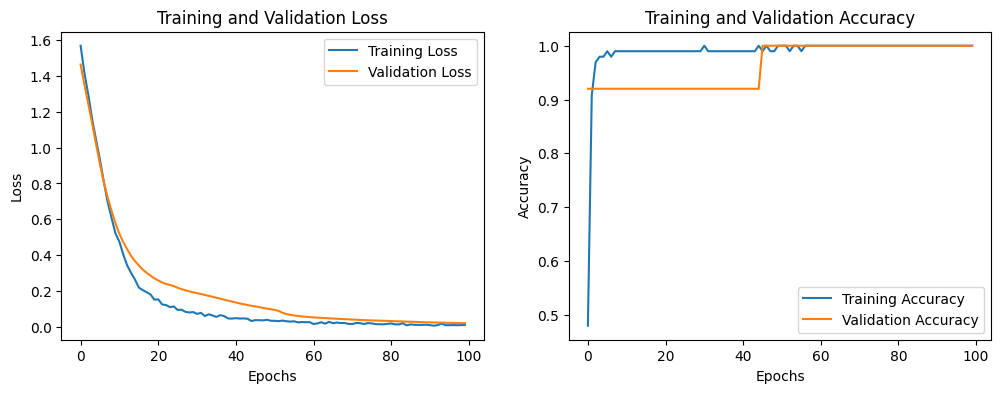

In [21]:
# Plot loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_128.history['loss'], label='Training Loss')
plt.plot(history_128.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_128.history['accuracy'], label='Training Accuracy')
plt.plot(history_128.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

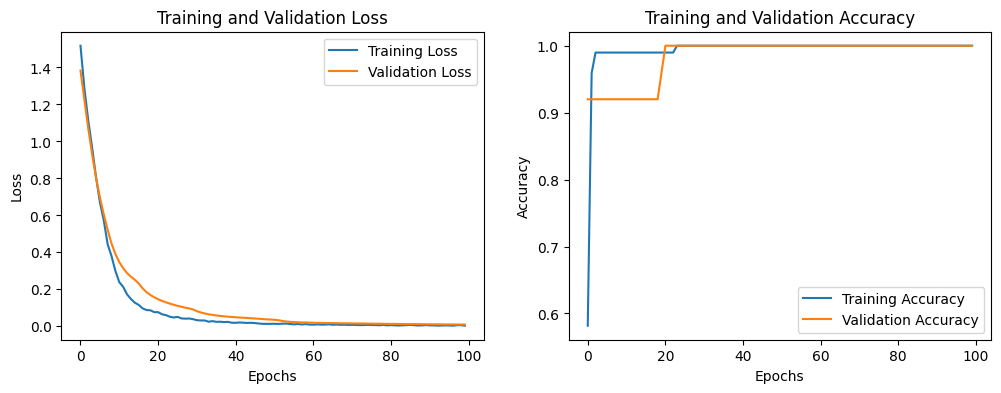

In [22]:
# Plot loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_256.history['loss'], label='Training Loss')
plt.plot(history_256.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_256.history['accuracy'], label='Training Accuracy')
plt.plot(history_256.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

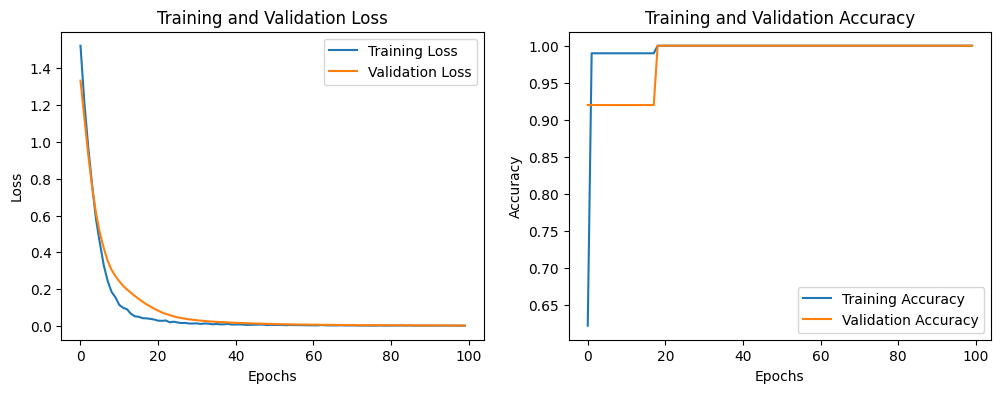

In [23]:
# Plot the training history

# Plot loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_512.history['loss'], label='Training Loss')
plt.plot(history_512.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_512.history['accuracy'], label='Training Accuracy')
plt.plot(history_512.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

Confusion matrix model 512

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predicting labels for the training and testing data using the trained model
ypreds_train = model_512.predict(X_train_norm)
ypreds_test = model_512.predict(X_test_norm)

# Convert predictions from one-hot encoding back to labels
ypreds_train_labels = np.argmax(ypreds_train, axis=1)
ypreds_test_labels = np.argmax(ypreds_test, axis=1)

# Calculating accuracy scores
train_accuracy = accuracy_score(Y_train, ypreds_train_labels)
test_accuracy = accuracy_score(Y_test, ypreds_test_labels)

# Print the accuracy scores
print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

# Evaluate other metrics like precision, recall, etc.
print('\n classification report:')
print(classification_report(Y_test, ypreds_test_labels))

1/1 [==============================] - 0s 20ms/step
Training Accuracy: 1.0
Test Accuracy: 1.0

 classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



## Visualizing confusion matrix

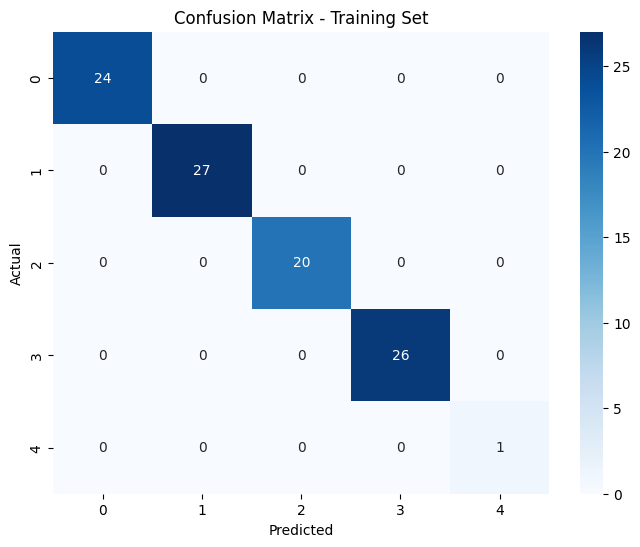

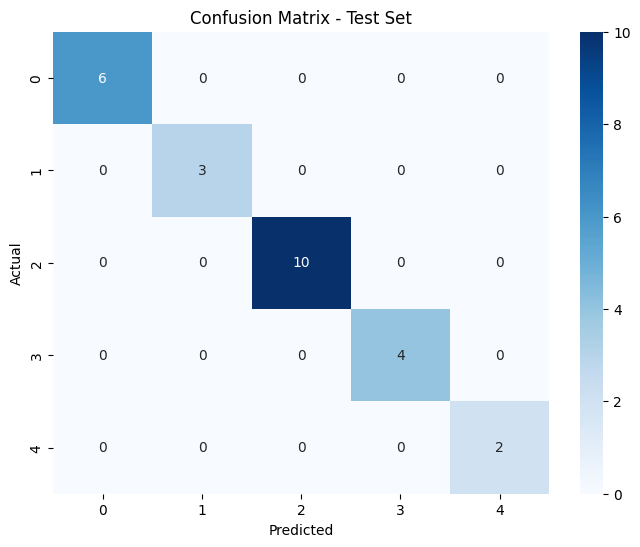

In [25]:
# Import seaborn for data visualization
import seaborn as sns

# Confusion matrix for training set
conf_matrix_train = confusion_matrix(Y_train, ypreds_train_labels)

# Confusion matrix for test set
conf_matrix_test = confusion_matrix(Y_test, ypreds_test_labels)

# Visualizing confusion matrix using seaborn heatmap
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(conf_matrix_train, 'Confusion Matrix - Training Set')
plot_confusion_matrix(conf_matrix_test, 'Confusion Matrix - Test Set')

## Test predicting an image

1/1 [==============================] - 0s 31ms/step


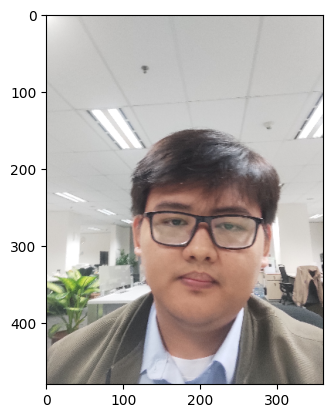

In [26]:
# Load the image
t_img = cv.imread("data/18999687-c74f-419e-9377-8f4056b41612/abed_3.jpg")

# Convert the image to RGB
t_img = cv.cvtColor(t_img, cv.COLOR_BGR2RGB)

# Resize the image to the new size while maintaining aspect ratio
new_size = (480, 480)
height, width, _ = t_img.shape
scale = min(new_size[0] / width, new_size[1] / height)
new_width = int(width * scale)
new_height = int(height * scale)
resized_img = cv.resize(t_img, (new_width, new_height))

# Show the image
plt.imshow(resized_img) # RGB 

# Extract the coordinates and size of the bounding box from the first detection result
x,y,w,h = img_detector.detect_faces(resized_img)[0]['box']

1/1 [==============================] - 0s 64ms/step


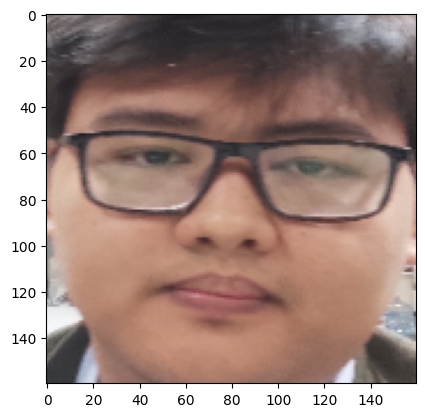

In [27]:
# Crop the detected face region from t_img using the bounding box coordinates
resized_img = resized_img[y:y+h, x:x+w]

# Resize the cropped face image to 160x160
resized_img = cv.resize(resized_img, (160,160))
plt.imshow(resized_img)

# Get the embedding (feature vector) for the resized face image using the get_embedding function (Facenet)
test_img = get_embedding(resized_img)

Labels by name:

- 13b6aafe-ab44-4e90-a841-45b281462955 = Vicky Maulana
- 18999687-c74f-419e-9377-8f4056b41612 = Abednego Christianyoel Rumagit
- 894f86f4-7309-4e4e-975c-90db5f586884 = Syahrial Alzaidan
- cabc5986-71cf-439d-bd8e-b285937f6fb5 = Gibran Fasha Ghazanfar
- e1b4262e-6346-4f82-8e7a-ff3a82888435 = Budi Adrianto

In [28]:
# Convert the embedding to the correct shape (2D array)
test_embedding = np.expand_dims(test_img, axis=0)

# Make Prediction
predict_proba = model_512.predict(test_embedding)[0]

# Decode the prediction
predicted_class = np.argmax(predict_proba)
predicted_label = encoder.inverse_transform([predicted_class])[0]
confidence_score = predict_proba[predicted_class]

# Check confidence score and determine if the prediction should be considered unknown
if confidence_score < 0.9:
    predicted_label = "unknown"

# Convert confidence score to percentage
confidence_percentage = confidence_score * 100

# Print predicted label and confidence score in percentage
print(f"Predicted Label: {predicted_label}")
print(f"Confidence Score: {confidence_percentage:.2f}%")

1/1 [==============================] - 0s 21ms/step
Predicted Label: 18999687-c74f-419e-9377-8f4056b41612
Confidence Score: 99.92%


In [29]:
# Read labels from the labels.txt file
with open('labels.txt', 'r') as file:
    LABEL = [line.strip() for line in file.readlines()]

# Fit the label encoder
encoder = LabelEncoder()
encoder.fit(LABEL)

# List all probabilities
print("Probabilities for each class:")
for label, proba in zip(LABEL, predict_proba):
    print(f"{label}: {proba * 100:.2f}%")

Probabilities for each class:
13b6aafe-ab44-4e90-a841-45b281462955: 0.00%
18999687-c74f-419e-9377-8f4056b41612: 99.92%
894f86f4-7309-4e4e-975c-90db5f586884: 0.03%
cabc5986-71cf-439d-bd8e-b285937f6fb5: 0.04%
e1b4262e-6346-4f82-8e7a-ff3a82888435: 0.01%


## Save Model

In [30]:
# Save the model
model_512.save('mtcnn_facenet_mlp_model.h5')